In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.layers import Conv2D, UpSampling2D, InputLayer
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imsave
import numpy as np
#from google.colab import files
import cv2

from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

(224, 224, 3)


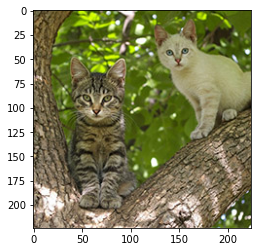

In [7]:
img = cv2.imread("img.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

print(img.shape)

In [10]:
# Преобразует изображение в формат LAB и выделяет яркостную с 2мя цветовыми компонентами
def processed_image(img):
    image = img.resize( (256, 256), Image.BILINEAR)
    image = np.array(image, dtype=float)
    size = image.shape
    lab = rgb2lab(1.0/255*image)
    X, Y = lab[:,:,0], lab[:,:,1:]
    # X - яркость [0:100], Y - цвет [-1:1]
    Y /= 128    # нормируем выходные значение в диапазон от -1 до 1
    X = X.reshape(1, size[0], size[1], 1) # формируем тензоры размерности, нужной для входа (батч, размеры самого изображения, ко-во цветовых каналов)
    Y = Y.reshape(1, size[0], size[1], 2)
    return X, Y, size

In [11]:
X, Y, size = processed_image(img)

TypeError: 'tuple' object cannot be interpreted as an integer

In [46]:
# Модель из статьи по расскрасске изображений
# https://github.com/baldassarreFe/deep-koalarization
#http://iizuka.cs.tsukuba.ac.jp/projects/colorization/data/colorization_sig2016.pdf
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1))) # изображение размерности x,y с 1 цветовым каналом
model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) # padding='same' - размер карты признаков не меняется
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)) # strides=2 - шаг сканирования
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same')) # tanh, чтобы получился диапазон от -1 до 1
model.add(UpSampling2D((2, 2)))
# 3 раза уменьшили, а потом 3 раза увеличили карту признаков


In [47]:
model.compile(optimizer='adam', loss='mse') # mse - минимум среднего квадрата ошибки
model.fit(x=X, y=Y, batch_size=1, epochs=50)

NameError: name 'X' is not defined

In [48]:
upl = files.upload()
names = list(upl.keys())
img = Image.open(BytesIO(upl[names[0]]))
X, Y, size = processed_image(img)

NameError: name 'files' is not defined

In [49]:
output = model.predict(X) # на выходе получили 2 цветовые компоненты
output *= 128 # увеличили на 128, чтобы выйти из диапазона -1:1
min_vals, max_vals = -128, 127
ab = np.clip(output[0], min_vals, max_vals) # ограничили компоненты цветовым диапазоном

NameError: name 'output' is not defined

In [50]:
cur = np.zeros((size[0], size[1], 3)) # коллекция со сгенерированным цветным изображением
cur[:,:,0] = np.clip(X[0][:,:,0], 0, 100) # помещение яркости
cur[:,:,1:] = ab # помещение цвета
plt.subplot(1, 2, 1)
plt.imshow(img) # исходное
plt.subplot(1, 2, 2)
plt.imshow(lab2rgb(cur)) # сгенерированное

NameError: name 'size' is not defined